<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# RNN Text Classifier

by Fabian Märki

## Summary
The aim of this notebook is to build a RNN text classifier. It utilize pretrained word embeddings in order to take advantage of [transfer learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning) in NLP. Additionally, it sets the stage for hyperparameter tuning and model design optimization.

## Links
- [Enabling GPU on Google Colab](https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm)

This notebook contains assigments: <font color='red'>Questions are written in red.</font>

<a href="https://colab.research.google.com/github/markif/2023_HS_DAS_NLP_Notebooks/blob/master/06_a_RNN_Text_Classifier.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'

from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.system import set_log_level
from fhnw.nlp.utils.colab import runs_on_colab

import pandas as pd
import numpy as np

set_log_level(2)
import tensorflow as tf

In [2]:
from fhnw.nlp.utils.system import system_info
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 5.19.0-41-generic
Python version: 3.8.10
CPU cores: 6
RAM: 31.12GB total and 24.1GB available
Tensorflow version: 2.12.0
GPU is available
GPU is a NVIDIA GeForce RTX 2070 with Max-Q Design with 8192MiB


Download the [cleaned](https://github.com/markif/2023_HS_CAS_NLP_LAB_Notebooks/blob/master/02_a_Text_Cleaning.ipynb) and [preprocessed](https://github.com/markif/2023_HS_CAS_NLP_LAB_Notebooks/blob/master/02_b_Text_Normalization.ipynb) doctor reviews dataset. 

In [3]:
%%time
download("https://drive.switch.ch/index.php/s/0hE8wO4FbfGIJld/download", "data/german_doctor_reviews_tokenized.parq")
data = load_dataframe("data/german_doctor_reviews_tokenized.parq")

CPU times: user 6.65 s, sys: 1.51 s, total: 8.16 s
Wall time: 4.56 s


Exclude *neutral* ratings so that the task becomes a binary classification.

In [4]:
# remove all neutral sentimens
data = data.loc[(data["label"] != "neutral")]
data.shape

(331187, 10)

In [5]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, magura, erste, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,..."


Import some helper functions...

In [6]:
from fhnw.nlp.utils.ploting import plot_history

from fhnw.nlp.utils.params import build_model_cnn
from fhnw.nlp.utils.params import build_model_rnn
from fhnw.nlp.utils.params import build_preprocessed_dataset
from fhnw.nlp.utils.params import compile_model
from fhnw.nlp.utils.params import create_label_binarizer_and_set
from fhnw.nlp.utils.params import create_text_preprocessor
from fhnw.nlp.utils.params import dataframe_to_dataset
from fhnw.nlp.utils.params import extract_embedding_layer_and_set
from fhnw.nlp.utils.params import extract_text_vectorization_and_set
from fhnw.nlp.utils.params import extract_vocabulary_and_set
from fhnw.nlp.utils.params import get_train_test_split
from fhnw.nlp.utils.params import re_compile_model
from fhnw.nlp.utils.params import save_model
from fhnw.nlp.utils.params import train_model

Setup the *params* dictionary which is used to specify hyperparameters and model design choices (and is also used to store intermediate results).  This sets the stage for a possible hyperparameter tuning and model design optimization (not part of this notebook).

<font color='red'>**TASK: You might want to try different *word embeddings* by changing the `embedding_type` parameter (values: *fasttext*, *bytepair*, *word2vec*).**</font>

In [7]:
params = {
    "verbose": True,
    "shuffle": True,
    "n_samples": len(data),
    # modify batch_size in case you experience memory issues
    "batch_size": 128,
    "X_column_name": "text_clean",
    "y_column_name": "label",
    # modify to try different word embeddings
    "embedding_type": "fasttext",
    "embedding_dim": 300,
    "embedding_trainable": False,
    "embedding_fasttext_model": "cc.de.300.bin",
    "embedding_word2vec_model_url": "https://cloud.devmount.de/d2bc5672c523b086/german.model",
    "embedding_spacy_model": "de_core_news_md",
    "embedding_tensorflow_hub_url": "https://tfhub.dev/google/nnlm-de-dim128-with-normalization/2",
    "model_type": "rnn",
}

if runs_on_colab() and params["embedding_type"] == "fasttext":
    # colab as problems handling such large files
    model_name = "cc.de.50.bin"
    download("https://drive.switch.ch/index.php/s/fncH84BgISMlT3v/download", model_name)
    params["embedding_dim"] = 50
    params["embedding_fasttext_model"] = model_name
    

...extract the vocabulary...

In [8]:
create_label_binarizer_and_set(params, data)
extract_vocabulary_and_set(params, data)

Inferred classification type: binary
Median sequence length: 46
Percentil (0.98) cutoff sequence length: 230
Max sequence length: 408
Used embedding sequence length: 230


...build the TextVectorization layer...

In [9]:
extract_text_vectorization_and_set(params)

Vocabulary length: 189790


...import and load word embeddings...

In [10]:
%%time

extract_embedding_layer_and_set(params)

/usr/local/lib/python3.8/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Embedding type: fasttext
Number of null word embeddings: 9
Words not found in total: 9
Words without embedding (9/9): ['', 'úm', 'ìn', 'üw', 'èn', 'jé', 'äk', 'öä', 'öz']
CPU times: user 6.44 s, sys: 3.19 s, total: 9.63 s
Wall time: 9.61 s


...prepare the training/test/validation data...

In [11]:
data_train, data_test = get_train_test_split(params, data)
data_train, data_val = get_train_test_split(params, data_train)

dataset_train = dataframe_to_dataset(params, data_train)
dataset_test = dataframe_to_dataset(params, data_test)
dataset_val = dataframe_to_dataset(params, data_val)

264949 train examples
66238 test examples
211959 train examples
52990 test examples


In [12]:
for text, labels in dataset_train.take(1):
    print(text)
    print(labels)

tf.Tensor(b'tolle \xc3\xa4rztin , h\xc3\xb6rt auch mal zu auch wenn es l\xc3\xa4nger dauert . sind umgezogen und halten ihr troztdem die treue ! ! wurde nie entt\xc3\xa4uscht', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


Next we will build our data pipeline. 

In [13]:
training_preprocessor = create_text_preprocessor(params, True)

In [14]:
dataset_train_preprocessed = build_preprocessed_dataset(params, dataset_train, True, training_preprocessor)
dataset_val_preprocessed = build_preprocessed_dataset(params, dataset_val, False, training_preprocessor)

Next we will build our model. 

<font color='red'>**TASK: Improve the RNN model defined in `build_model_rnn` (play with rnn_units, activation function, rnn type ([RNN](https://keras.io/api/layers/recurrent_layers/simple_rnn/), [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/), [GRU](https://keras.io/api/layers/recurrent_layers/gru/)), model design ([Bidirectional](https://keras.io/api/layers/recurrent_layers/bidirectional/), [Multi-Layer RNN](https://wandb.ai/lavanyashukla/visualize-models/reports/How-to-stack-multiple-LSTMs-in-keras---VmlldzoxOTg2MTY) ) etc...)**</font>

You might get inspiration from:
- [Working with RNNs](https://keras.io/guides/working_with_rnns/)
- [Develop a Bidirectional LSTM For Sequence Classification](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/)

In [15]:
def build_model_rnn(params):
    """Builds a rnn classifier (only partially) based on the provided params 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
    
    from tensorflow import keras
    
    # choose the output activation function based on the classification type
    classification_type = params.get("classification_type", "binary")
    if classification_type == "binary":
        output_activation = "sigmoid"
    elif classification_type == "multi-class":
        output_activation = "softmax"
    elif classification_type == "multi-label":
        output_activation = "sigmoid"
    else:
        raise TypeError("Unknown classification_type "+classification_type)
    
    X_column_name = params.get("X_column_name", "text_clean")
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vectorize_layer = params[computed_objects_column_name]["vectorize_layer"]
    embedding_layer = params[computed_objects_column_name]["embedding_layer"]
    label_binarizer = params[computed_objects_column_name]["label_binarizer"]
    output_classes = len(label_binarizer.classes_)
    output_classes = output_classes if output_classes > 2 else 1
    
    
    # Build a separate model for training
    model_train = keras.Sequential(name="rnn_train")
    # The input for the training model is already processes, i.e. vectorized.
    # Offloading this step and prefetching the data provides speedup during training 
    # After vectorization we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model_train.add(keras.Input(shape=(None,), dtype=tf.int64, name="preprocessed_input"))
    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'. 
    model_train.add(embedding_layer)
    
    # build the RNN
    rnn_units = 32
    model_train.add(keras.layers.Bidirectional(
        # dropout (regularization) could make sense here
        keras.layers.LSTM(
            rnn_units, 
            return_sequences=True # needed since we do a GlobalMaxPool1D
        )
    ))
    # add global max pooling
    model_train.add(keras.layers.GlobalMaxPool1D(name="global_max_pool"))
    # an alternative
    # model_train.add(keras.layers.GlobalAveragePooling1D(name="global_average_pool"))
    # another alternative (but ensure fixed time dimension by setting TextVectorization.output_sequence_length and Embedding.input_length)
    # model_train.add(keras.layers.Flatten(name="flatten"))
    # model_train.add(keras.layers.Dense(100, activation="relu", name="dense"))
    
    # do not forget Dropout (regularization) for a more sophisticated model
    
    # add the classification head
    model_train.add(keras.layers.Dense(output_classes, activation=output_activation, name="prediction"))
    
    
    # Next we build the inference model that also contains the preprocessing (all in one)
    model_inference = keras.Sequential(name="rnn_inference")
    # A text input layer
    model_inference.add(keras.layers.InputLayer(input_shape=(1,), dtype=tf.string, name=X_column_name))
    # Then we vectorize the text.
    # After this layer, we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model_inference.add(vectorize_layer)
    # Next we just re-use the training model 
    model_inference.add(model_train)
    
    return model_train, model_inference

In [16]:
training_model, inference_model = build_model_rnn(params)

In [17]:
training_model.summary()

Model: "rnn_train"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         56937000  
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         85248     
 l)                                                              
                                                                 
 global_max_pool (GlobalMaxP  (None, 64)               0         
 ooling1D)                                                       
                                                                 
 prediction (Dense)          (None, 1)                 65        
                                                                 
Total params: 57,022,313
Trainable params: 85,313
Non-trainable params: 56,937,000
_________________________________________________________________


In [18]:
inference_model.summary()

Model: "rnn_inference"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 rnn_train (Sequential)      (None, 1)                 57022313  
                                                                 
Total params: 57,022,313
Trainable params: 85,313
Non-trainable params: 56,937,000
_________________________________________________________________


Compile and train the model.

In [19]:
compile_model(params, training_model)

In [20]:
params["training_epochs"] = 10
history = train_model(params, training_model, dataset_train_preprocessed, dataset_val_preprocessed)

Epoch 1/10
1656/1656 [==============================] - 38s 19ms/step - loss: 0.0867 - accuracy: 0.9672 - val_loss: 0.0581 - val_accuracy: 0.9786
Epoch 2/10
1656/1656 [==============================] - 29s 18ms/step - loss: 0.0542 - accuracy: 0.9801 - val_loss: 0.0570 - val_accuracy: 0.9789
Epoch 3/10
1656/1656 [==============================] - 29s 18ms/step - loss: 0.0459 - accuracy: 0.9833 - val_loss: 0.0546 - val_accuracy: 0.9805
Epoch 4/10
1656/1656 [==============================] - 29s 18ms/step - loss: 0.0400 - accuracy: 0.9856 - val_loss: 0.0495 - val_accuracy: 0.9826
Epoch 5/10
1656/1656 [==============================] - 30s 18ms/step - loss: 0.0358 - accuracy: 0.9872 - val_loss: 0.0502 - val_accuracy: 0.9814
Epoch 6/10
1656/1656 [==============================] - 30s 18ms/step - loss: 0.0317 - accuracy: 0.9888 - val_loss: 0.0554 - val_accuracy: 0.9801
Epoch 7/10
1656/1656 [==============================] - 30s 18ms/step - loss: 0.0279 - accuracy: 0.9904 - val_loss: 0.0576 -

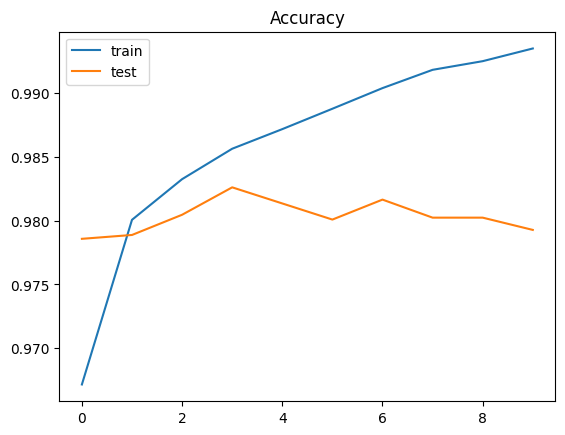

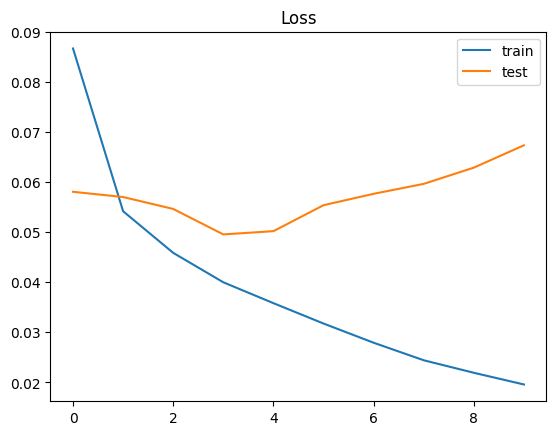

In [21]:
plot_history(history)

Quite overfitted. Training could stop after ~3 epochs and some regularizations (like dropout) could also make sense.  

Let's see if it is possible to further improve the model by unfreezing the embedding layer.

Also see https://www.tensorflow.org/guide/keras/transfer_learning

In [22]:
# Unfreeze all layers (i.e. make embeddings trainable)
training_model.trainable = True
training_model.summary()

Model: "rnn_train"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         56937000  
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         85248     
 l)                                                              
                                                                 
 global_max_pool (GlobalMaxP  (None, 64)               0         
 ooling1D)                                                       
                                                                 
 prediction (Dense)          (None, 1)                 65        
                                                                 
Total params: 57,022,313
Trainable params: 57,022,313
Non-trainable params: 0
_________________________________________________________________


In [23]:
re_compile_model(params, training_model)

In [24]:
params["training_epochs"] = 2
history = train_model(params, training_model, dataset_train_preprocessed, dataset_val_preprocessed)

Epoch 1/2
1656/1656 [==============================] - 79s 44ms/step - loss: 0.0141 - accuracy: 0.9957 - val_loss: 0.0606 - val_accuracy: 0.9814
Epoch 2/2
1656/1656 [==============================] - 71s 43ms/step - loss: 0.0087 - accuracy: 0.9980 - val_loss: 0.0599 - val_accuracy: 0.9820


Check performance on all data.

In [25]:
from fhnw.nlp.utils.params import predict_classification
from fhnw.nlp.utils.ploting import report_classification_results

2588/2588 [==============================] - 20s 7ms/step
Set Population: 331187
Accuracy: 0.9927


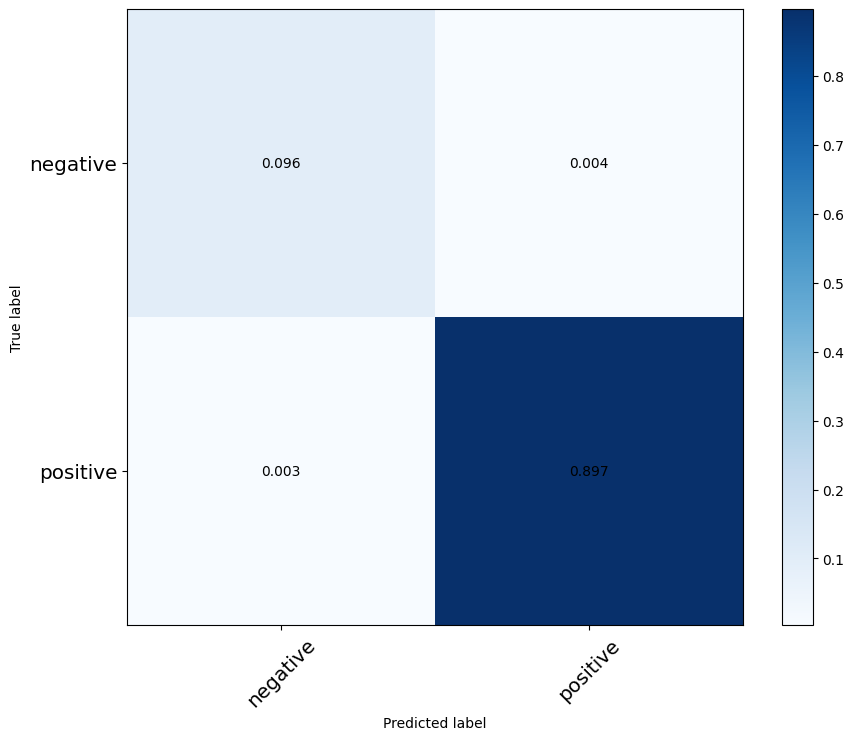

              precision    recall  f1-score   support

    negative       0.97      0.96      0.96     33022
    positive       1.00      1.00      1.00    298165

    accuracy                           0.99    331187
   macro avg       0.98      0.98      0.98    331187
weighted avg       0.99      0.99      0.99    331187

CPU times: user 37.9 s, sys: 1.43 s, total: 39.3 s
Wall time: 30.1 s


In [26]:
%%time

preprocessor = create_text_preprocessor(params, False)

y, y_pred, y_pred_prob = predict_classification(params, data, training_model, preprocessor)

report_classification_results(params, y, y_pred)

Check performance on test data.

518/518 [==============================] - 4s 7ms/step
Set Population: 66238
Accuracy: 0.9825


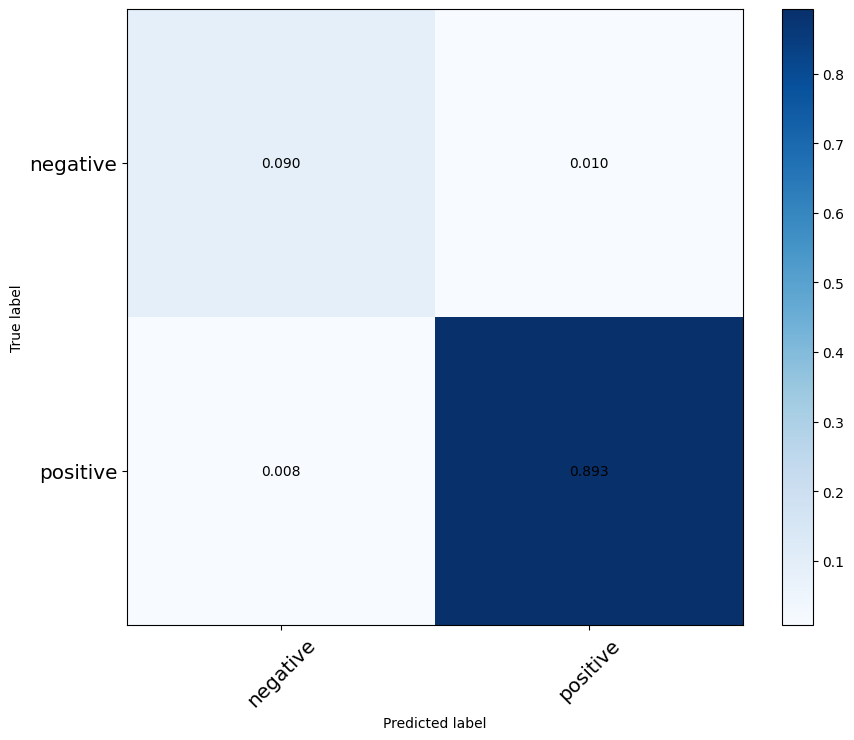

              precision    recall  f1-score   support

    negative       0.92      0.90      0.91      6604
    positive       0.99      0.99      0.99     59634

    accuracy                           0.98     66238
   macro avg       0.96      0.95      0.95     66238
weighted avg       0.98      0.98      0.98     66238

CPU times: user 7.54 s, sys: 385 ms, total: 7.92 s
Wall time: 5.85 s


In [27]:
%%time

preprocessor = create_text_preprocessor(params, False)

y, y_pred, y_pred_prob = predict_classification(params, data_test, training_model, preprocessor)

report_classification_results(params, y, y_pred)